# Estudo de Caso: KDD Cup 2009

A Administração de Relacionamento com o Consumidor é um elemento-chave das estratégias modernas de marketing. A maneira mais prática de adquirir conhecimento sobre consumidores é produzindo pontuações. Uma pontuação é a saída de um modelo e serve como avaliação de todas as instâncias de uma variável-alvo que se pretenda explicar. Ferramentas que produzem pontuações permitem projetar informações quantificáveis em uma dada população. A pontuação é calculada usando variáveis de entrada que descrevem as instâncias. As pontuações são então usadas pelo sistema de informação, por exemplo, para personalizar o relacionamento com o consumidor.

Em 2009, a conferência Knowledge Discovery and Data Mining (KDD) lançou um desafio envolvendo aprendizagem de máquina. Ela disponibilizou dados de consumidores da empresa de telecomunicações francesa Orange, que deveriam ser utilizados para a construção de um modelo capaz de prever três comportamentos do consumidor. A planilha fornecida tem 50000 instâncias e 230 variáveis, sendo as primeiras 190 variáveis numéricas e as demais 40 categóricas. As variáveis de saída do modelo eram o cancelamento da conta ('churn'), a tendência de usar novos produtos e serviços ('appetency') e a propensão para comprar upgrades ou adicionais com maior margem de lucro quando apresentados (upselling), fornecidos de forma binária (-1 para *não*, 1 para *sim*).

O trabalho apresentado aqui envolve a criação de um modelo para predição de *churn*, *appetency* e *upselling* com base nos dados fornecidos dos clientes da Orange. O critério para avaliação do modelo será a métrica AUC, que dimensiona o trade-off entre taxa de falsos positivos e taxa de verdadeiros positivos: quanto mais próximo de 1, menor o trade-off e melhor o modelo.

Detalhes sobre a competição: https://www.kdd.org/kdd-cup/view/kdd-cup-2009

# Etapa 1: Modelando 'churn' (cancelamento da conta)

### Importando as dependências

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Atalhos do Colab

+ Add Code Cell : CTRL + M + B
+ Delete Cell : CTRL + M + D
+ Exec Cell: CTRL + ENTER / SHIFT + ENTER

### Carregando os dados

Para Carregar dados no Colab, use a barra lateral, nas parte de Files. Aí, faça o upload dos arquivos. Esse diretório é uma máquina virtual linux, e você deve fazer os uploads junto da pasta "sample_data" que fica na pasta "content" da raiz. 

Enfim, fazendo o upload, você pode selecionar com o btão direito "Copy Path" para copiar o atalho correto do arquivo.

OBS: Colab Demora para fazer uploa de arquivos, mesmo 20Mb demora uns 20 min.

In [0]:
# na_filter = FALSE ==> Significa que não é para tratar valores faltantes
features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/files/orange_small_train.data', sep = '\t', na_filter = False)

# header = None => Não há cabeçalho
outcome = pd.read_csv('/content/drive/My Drive/Colab Notebooks/files/orange_small_train_churn.labels', header = None)

In [7]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,,,,,,1526,7,,,,,,184,,,,,,,,464,580,,14,128,,,166.56,,,,,,,0,,,3570,,,...,,bZkvyxLkBI,RO12,,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,,,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,,uKAI,L84s,XfqtO3UdzaXh_,,,,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,,,xb3V,RAYp,F2FyR07IdsN7I,,
1,,,,,,525,0,,,,,,0,,,,,,,,168,210,,2,24,,,353.52,,,,,,,0,,,4764966,,,...,,CEat0G8rTN,RO12,,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,,,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,,uKAI,L84s,NhsEn4L,,,,kZJyVg2,,,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,,,fKCe,RAYp,F2FyR07IdsN7I,,
2,,,,,,5236,7,,,,,,904,,,,,,,,1212,1515,,26,816,,,220.08,,,,,,,0,,,5883894,,,...,,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,,uKAI,L84s,UbxQ8lZ,,TTGHfSv,,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,
3,,,,,,,0,,,,,,0,,,,,,,,,0,,,0,,,22.08,,,,,,,0,,,0,,,...,,jg69tYsGvO,RO12,,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,,,W8mQ,9_Y1,YULl,VpdQ,,me75fM6ugJ,kIsH,,uKAI,Mtgm,NhsEn4L,,,,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,,,FSa2,RAYp,F2FyR07IdsN7I,,
4,,,,,,1029,7,,,,,,3216,,,,,,,,64,80,,4,64,,,200,,,,,,,0,,,0,,,...,,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,,uKAI,L84s,XfqtO3UdzaXh_,,SJs3duv,,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,


In [9]:
outcome.head()

,0
0,Var1\tVar2\tVar3\tVar4\tVar5\tVar6\tVar7\tVar8...
1,\t\t\t\t\t1526\t7\t\t\t\t\t\t184\t\t\t\t\t\t\t...
2,\t\t\t\t\t525\t0\t\t\t\t\t\t0\t\t\t\t\t\t\t\t1...
3,\t\t\t\t\t5236\t7\t\t\t\t\t\t904\t\t\t\t\t\t\t...
4,\t\t\t\t\t\t0\t\t\t\t\t\t0\t\t\t\t\t\t\t\t\t0\...


In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: float64(2), int64(1), object(227)
memory usage: 87.7+ MB


In [11]:
outcome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 1 columns):
0    50001 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


In [12]:
# Respectivas rows que dão churn (1) e que nâo dâo churn (-1)
outcome[0].value_counts()

\t\t\t\t\t35\t0\t\t\t\t\t\t0\t\t\t\t\t\t\t\t32\t40\t\t0\t32\t\t\t166.56\t\t\t\t\t\t\t0\t\t\t734472\t\t\t\t\t\t0\t\t\t\t\t\t\t\t\t\t\t\t\t0.4033326\t\t\t\t\t\t\t\t9\t\t\t\t\t\t\t3\t14\t0\t\t0\t\t0\t\t\t457551\t\t5\t\t0\t\t\t\t\t\t\t\t\t28047\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t8\t\t\t0\t-623508\t\t\t\t\t\t65\t\t\t\t6\t\t0\t4\t\t\t\t\t\t0\t4334680\t697154\t\t\t\t\t\t0\t\t\t0\t0\t\t\t\t\t0\t\t\t\t5505680\t\t\t\t\t\t\t4\t\t\t0\t\t\t\t\t\t\t\t\t\t0\t\t\t\t\t\t\t\t0\t\t\t\t\t\t\t\t\t\t\tHYTvyx7ejg\tAERks4l\t\ttaul\t1K8T\t7wJ6\trP4_WUr\tpUwdAyB\t\t\twvC_\t9_Y1\tYGOC\tVpdQ\tIYzP\tDHn_WUyBhW_whjA88g9bvA64_\tkIsH\t\tuKAI\tL84s\tJBfYVit4g8\t\t\t\tTDc_9Yi\t_nXH\tcJvF\tFzaX\t_viNkDm\tAl6ZaUT\tsCAs5nE\tLM8l689qOp\t\t\tszEZ\t02N6s8f\txwM2aC7IdeMC0\t\t                                                             1
\t\t\t\t\t1890\t7\t\t\t\t\t\t80\t\t\t\t\t\t\t\t152\t190\t\t0\t8\t\t\t286.96\t\t\t\t\t\t\t0\t\t\t3326160\t\t\t\t\t\t0\t\t\t\t\t\t\t\t\t\t\t\t\t6.739158\t\t\t\t\t\t\t\t9\t\t\t\t\t\t\t3\t36\t63\t\t3119

Perceba que os dados tem nomenclaturas estranhas (Var1 à Var230) e que o valor dos dados é estranho (Tanto que as string nâo são algo detectável).

Isso acontece porque **OS DADOS SÃO MASCARADOS PARA PRESERVAR A PRIVACIDADE**

### Identificando as variáveis numéricas e categóricas

In [13]:
# Listandos todos os nomes das variáveis
all_vars = np.array(features.columns)
all_vars[:50] # Exemplo até 50

array(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
       'Var9', 'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15',
       'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22',
       'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29',
       'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36',
       'Var37', 'Var38', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43',
       'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50'],
      dtype=object)

In [14]:
# Pela definição do problema as primeiras 190 são numéricas
num_vars = np.array(all_vars[:190])
num_vars[189] # mostrando o ultimo para confirmar que foi de 0 à 190

'Var190'

In [15]:
# As categóricas são as de 190 até o final
cat_vars = np.array(all_vars[190:])
cat_vars

array(['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196',
       'Var197', 'Var198', 'Var199', 'Var200', 'Var201', 'Var202',
       'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208',
       'Var209', 'Var210', 'Var211', 'Var212', 'Var213', 'Var214',
       'Var215', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220',
       'Var221', 'Var222', 'Var223', 'Var224', 'Var225', 'Var226',
       'Var227', 'Var228', 'Var229', 'Var230'], dtype=object)

### Verificando a consistência das variáveis

Vamso verificar os tipos das colunas e se, emc ada coluna, todos os dados estão consistêntes: se uma coluna de `int` só tem `int` e da mesma forma com `string`

In [16]:
# Perceba que: de Va1 à Var190 deveria ser int, mas não é
features.dtypes

Var1      object
Var2      object
Var3      object
Var4      object
Var5      object
           ...  
Var226    object
Var227    object
Var228    object
Var229    object
Var230    object
Length: 230, dtype: object

In [17]:
features["Var1"].value_counts()

       49298
0        380
8        138
16        81
24        46
32        23
40        10
48         6
56         5
72         3
128        2
80         1
392        1
120        1
360        1
64         1
536        1
680        1
152        1
Name: Var1, dtype: int64

---

A partir desse ponto, o prof faz um processo para verificar se todas as colunas tem mesmo o tipo descrito e converte a colun para esse tipo no final, pois, inicialmente tá como `object`

In [0]:
counts_per_column = pd.DataFrame()
for col in num_vars:
  col_count = features.groupby(col).size()
  counts_per_column = counts_per_column.append(col_count, ignore_index = True)

In [19]:
counts_per_column.shape

(190, 351788)

In [20]:
counts_per_column.head()

,,0,120,128,152,16,24,32,360,392,40,48,536,56,64,680,72,8,80,5,102,105,10617,108,1083,111,1113,114,1155,117,12,123,1242,126,12633,129,12927,130668,1332,1344,...,6651.18,67723.29,6893.82,69126.48,69166.71,693.45,693.99,7.47,7030.17,70445.25,7135.65,72177.84,73467.99,7584.66,7597.979,76999.23,77.67,78230.79,7922.7,79562.08,8022.96,81838.62,82165.95,8328.149,843.57,8573.939,8615.25,8660.25,86645.08,87838.47,8900.46,920.88,9336.06,9379.709,9441.36,9607.05,966.15,9772.021,98.1,9857.88
0,49298.0,380.0,1.0,2.0,1.0,81.0,46.0,23.0,1.0,1.0,10.0,6.0,1.0,5.0,1.0,1.0,3.0,138.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48759.0,1240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48760.0,996.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48421.0,1561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48513.0,898.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
counts_per_column.T.shape

(351788, 190)

In [22]:
counts_per_column.T.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189
,49298.0,48759.0,48760.0,48421.0,48513.0,5529.0,5539.0,50000.0,49298.0,48513.0,48760.0,49442.0,5539.0,48760.0,50000.0,48513.0,48421.0,48421.0,48421.0,50000.0,5529.0,5009.0,48513.0,7230.0,5009.0,48513.0,48513.0,5011.0,49298.0,49298.0,50000.0,50000.0,49153.0,48759.0,5009.0,48759.0,48421.0,5009.0,50000.0,48759.0,...,49153.0,48421.0,5009.0,49298.0,48421.0,49306.0,48871.0,49127.0,48759.0,5009.0,48421.0,48759.0,5009.0,48421.0,49127.0,48513.0,50000.0,49298.0,50000.0,48759.0,48917.0,48513.0,5009.0,48421.0,50000.0,48760.0,48759.0,49354.0,48421.0,49298.0,5009.0,48421.0,48759.0,48759.0,50000.0,49298.0,49298.0,48759.0,28978.0,49667.0
0,380.0,1240.0,996.0,1561.0,898.0,976.0,13090.0,NaN,144.0,902.0,NaN,304.0,12258.0,1154.0,NaN,54.0,939.0,1200.0,1543.0,NaN,1815.0,2221.0,1052.0,16205.0,6629.0,1457.0,1467.0,388.0,694.0,195.0,NaN,NaN,523.0,1126.0,41219.0,692.0,964.0,9405.0,NaN,830.0,...,523.0,475.0,2221.0,273.0,1430.0,142.0,418.0,650.0,939.0,3848.0,1266.0,747.0,13457.0,1296.0,650.0,898.0,NaN,4.0,NaN,892.0,290.0,391.0,44857.0,964.0,NaN,1083.0,771.0,174.0,1289.0,144.0,41990.0,706.0,830.0,771.0,NaN,525.0,240.0,44.0,NaN,4.0
120,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,134.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,959.0,296.0,1.0,NaN,762.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2.0,...,2.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,56.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,NaN
128,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680.0,NaN,NaN,NaN,703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,124.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,968.0,NaN,NaN,1.0,664.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
counts_per_column = counts_per_column.T
counts_per_column.index = counts_per_column.index.astype('str')
counts_per_column.sort_index(inplace = True)
print('Primeiras dez categorias: ', counts_per_column.index[:10])
print('Últimas dez categorias: ', counts_per_column.index[(len(counts_per_column.index)-10):])

Primeiras dez categorias:  Index(['', '-10', '-1000060.0', '-10002.16', '-100034.8', '-1000420.0',
       '-1000468.0', '-1000496.0', '-1000516.0', '-1000548.0'],
      dtype='object')
Últimas dez categorias:  Index(['9999040', '999920', '9999240', '99993', '9999400', '9999440',
       '9999480', '99995', '99996', '999971'],
      dtype='object')


Fazer para variáveis Categóricas

In [0]:
counts_per_column = pd.DataFrame()
for col in cat_vars:
  col_count = features.groupby(col).size()
  counts_per_column = counts_per_column.append(col_count, ignore_index = True)

In [25]:
counts_per_column = counts_per_column.T
counts_per_column.index = counts_per_column.index.astype('str')
counts_per_column.sort_index(inplace = True)
print('Primeiras dez categorias: ', counts_per_column.index[:10])
print('Últimas dez categorias: ', counts_per_column.index[(len(counts_per_column.index)-10):])

Primeiras dez categorias:  Index(['', '000J', '0062', '00AD', '00ARusu', '00AYONy', '00AhP4J', '00J8E9a',
       '00JHTSP', '00L3'],
      dtype='object')
Últimas dez categorias:  Index(['zzQ9udm', 'zzQV', 'zzbGOGx', 'zzbGa54', 'zzcv6yg4s3UGv', 'zzfHvGh',
       'zzfLM_S', 'zzfUfAI', 'zzfo6HG', 'zzpZ'],
      dtype='object')


Substituir "" por `Nan`

In [0]:
features = features.replace('', np.nan)

In [27]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526,7,NaN,NaN,NaN,NaN,NaN,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464,580,NaN,14,128,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,3570,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168,210,NaN,2,24,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,4764966,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236,7,NaN,NaN,NaN,NaN,NaN,904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212,1515,NaN,26,816,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,5883894,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029,7,NaN,NaN,NaN,NaN,NaN,3216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,80,NaN,4,64,NaN,NaN,200,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [0]:
for col in num_vars:
  features[col] = features[col].astype('float')
for col in cat_vars:
  features[col] = features[col].astype('category')

In [29]:
features.dtypes

Var1       float64
Var2       float64
Var3       float64
Var4       float64
Var5       float64
            ...   
Var226    category
Var227    category
Var228    category
Var229    category
Var230    category
Length: 230, dtype: object

In [30]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: category(40), float64(190)
memory usage: 78.2 MB


### Seleção de variáveis

#### Variáveis com muitos valores faltantes


In [31]:
features.isna()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True
1,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,True,True,False,True,True,False,False,False,False,False,True,True,False,False,False,True,True
2,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True
4,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True
49996,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
49997,True,True,True,True,Tr

In [32]:
# Listando quantidade de Nan
## Lembre-se, são 50k rows, entâo, por exemplo:
## Var1: 39.298 ==> Tem muito Nan
empty_entries_per_column = features.isna().sum(axis = 0)
empty_entries_per_column

Var1      49298
Var2      48759
Var3      48760
Var4      48421
Var5      48513
          ...  
Var226        0
Var227        0
Var228        0
Var229    28432
Var230    50000
Length: 230, dtype: int64

48513.0


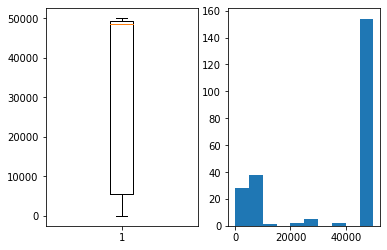

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(empty_entries_per_column)
ax2.hist(empty_entries_per_column)
median = empty_entries_per_column.median()
print(median) # Em média tem 43k de valores faltantes

# O gráfico a direita representa
## x: quantidade de dados faltantes
## y: quantidade de variáveis que tem essa qtd de dados 
##    faltantes

# Conclusão: Cerca de 150 variávei onde praticamente tudo é Nan

In [34]:
num_entries = len(features)
threshold = 0.25
num_entries * threshold

12500.0

Vamos usar variáveis que tenham mais de 12.500 valores válidos

In [35]:
# Essas são as variáevis válidas
keep_vars = np.array(features.columns[(empty_entries_per_column <= (num_entries * threshold))])
keep_vars

array(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25',
       'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73',
       'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109',
       'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132',
       'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149',
       'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var192',
       'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199',
       'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217',
       'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [0]:
# Filtrar pelas variáveis válidas
num_vars = [elem for elem in num_vars if elem in keep_vars]
cat_vars = [elem for elem in cat_vars if elem in keep_vars]

In [37]:
print("variáveis numéricas válidas", len(num_vars))
print("variáveis Categóricas válidas", len(cat_vars))

variáveis numéricas válidas 38
variáveis Categóricas válidas 28


Tratar a Falta de valores Numéricos: Fazer a Média

In [0]:
for col in num_vars:
  col_mean = features[col].mean()
  features[col] = features[col].fillna(col_mean)

In [0]:
for col in cat_vars:
  features[col] = features[col].cat.add_categories('missing')
  features[col] = features[col].fillna('missing')

In [40]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.000000,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.000000,580.0,NaN,14.000000,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.000000,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.000000,210.0,NaN,2.000000,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,missing,missing,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.000000,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.000000,1515.0,NaN,26.000000,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,1326.437116,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234.518225,0.0,NaN,4.507926,0.0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,missing,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.000000,7.0,NaN,NaN,NaN,NaN,NaN,3216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.000000,80.0,NaN,4.000000,64.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


#### Variáveis categóricas com muitas categorias

In [41]:
n_categories_per_feature = features[cat_vars].apply(lambda x: len(set(x)))
n_categories_per_feature

Var192      362
Var193       51
Var195       23
Var196        4
Var197      226
Var198     4291
Var199     5074
Var202     5714
Var203        6
Var204      100
Var205        4
Var206       22
Var207       14
Var208        3
Var210        6
Var211        2
Var212       81
Var216     2016
Var217    13991
Var218        3
Var219       23
Var220     4291
Var221        7
Var222     4291
Var223        5
Var226       23
Var227        7
Var228       30
dtype: int64

(array([21.,  1.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.00000e+00, 1.40090e+03, 2.79980e+03, 4.19870e+03, 5.59760e+03,
        6.99650e+03, 8.39540e+03, 9.79430e+03, 1.11932e+04, 1.25921e+04,
        1.39910e+04]),
 <a list of 10 Patch objects>)

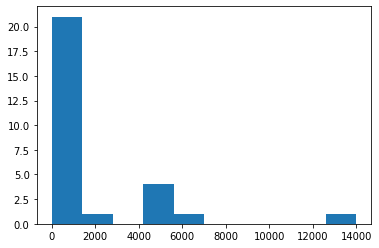

In [42]:
# Vamos criar um histograma
## Vamos observar que a maioria das categorias tem menos 
## de 2000, ou seja, são 75% das categorias
plt.hist(n_categories_per_feature)

Vamos definir o limiar de até 1400 categorias

In [0]:
cat_vars = np.array(n_categories_per_feature[n_categories_per_feature < 1400].index)

In [44]:
print("Quantidade de variáveis categpricas válidas", 
      len(cat_vars))
cat_vars

Quantidade de variáveis categpricas válidas 21


array(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203',
       'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210',
       'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

Juntar as variáveis Numéricas e Categóricas Válidas

In [0]:
features = features[list(num_vars) + list(cat_vars)]

In [46]:
features.shape

(50000, 59)

In [47]:
features.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var192,Var193,Var195,Var196,Var197,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var218,Var219,Var221,Var223,Var226,Var227,Var228
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,0.0,4.076907,9.0,36.0,35.0,1350864.0,0.0,7333.110000,5.0,12.0,104.00000,168.0,117625.60,1175.000000,6.0,720.0,0.0,1212385.0,69134.0,185.0,0.0,9.000000,397579.000000,1812252.0,142.0,38418.0,0.0,0.0,bZkvyxLkBI,RO12,taul,1K8T,lK27,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,cJvF,FzaX,oslk,jySVZNlOJy,xb3V,RAYp,F2FyR07IdsN7I
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,0.0,5.408032,9.0,26.0,0.0,2872928.0,3.0,151098.900000,25.0,2.0,40.00000,40.0,-356411.60,590.000000,72.0,0.0,8.0,4136430.0,357038.0,0.0,0.0,9.000000,278334.000000,10439160.0,32.0,238572.0,0.0,0.0,CEat0G8rTN,RO12,taul,1K8T,2Ix5,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,missing,FzaX,oslk,LM8l689qOp,fKCe,RAYp,F2FyR07IdsN7I
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,0.0,6.599658,9.0,130.0,518.0,1675776.0,0.0,16211.580000,40.0,58.0,312.00000,336.0,405104.00,3230.000000,114.0,5967.0,0.0,3478905.0,248932.0,800.0,0.0,36.000000,320565.000000,9826360.0,206.0,434946.0,0.0,0.0,eOQt0GoOh3,AERks4l,taul,1K8T,ffXs,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,uKAI,L84s,UbxQ8lZ,UYBR,FzaX,Al6ZaUT,jySVZNlOJy,Qu4f,02N6s8f,ib5G6X1eUxUn6
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,0.0,1.988250,9.0,12.0,0.0,0.0,0.0,103084.052693,0.0,0.0,60.88866,0.0,-275703.60,916.112185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.727665,294920.804255,0.0,0.0,0.0,0.0,0.0,jg69tYsGvO,RO12,taul,1K8T,ssAy,9_Y1,YULl,VpdQ,missing,me75fM6ugJ,kIsH,uKAI,Mtgm,NhsEn4L,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,0.0,4.552446,18.0,82.0,224.0,784448.0,0.0,37423.500000,0.0,0.0,32.00000,56.0,10714.84,215.000000,0.0,15111.0,0.0,150650.0,66046.0,3255.0,0.0,9.000000,267162.000000,644836.0,2.0,0.0,0.0,0.0,IXSgUHShse,RO12,taul,1K8T,uNkU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I


#### Seleção de variáveis baseada em árvore de decisão

Seleção de atributos: https://scikit-learn.org/stable/modules/feature_selection.html

1. Palio.. 100
2. Gol..... 010
3. Uno.... 011

Antes de Tudo, converteremos as variáveis categóricas para Números (`dumming`). 

Dumming não é um número interio, pois aí um dado por ser menor/maior que os demias, pode representar discrepância nos cálculos.

Mas, por exemplo, se as categorias fossem escolaridade, aí poderiamos usar a numériac normal, e assim indicar que Superior (4) > Médio (3).

o `pd.get_dummies(df)` vai pegar um DataFrame e vai converter as várias categoricas em novas colunas, contendo umonte de 0 e somente a categorias com 1.

In [0]:
features_c = pd.get_dummies(features)

In [59]:
features_c.shape

(50000, 1052)

In [58]:
# features_c é as features com o dumming nas categóricas
features_c.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var192_0G9vyxdMWg,Var192_0kQTmBU3gb,...,Var226_missing,Var227_02N6s8f,Var227_6fzt,Var227_RAYp,Var227_ZI9m,Var227_nIGXDli,Var227_nIGjgSB,Var227_vJ_w8kB,Var227_missing,Var228_0pzBWGkV3fbsGZN52DH,Var228_4rd_,Var228_55YFVY9,Var228_5oZS,Var228_6nxx00q6gnIF8ePJ3P3AEfZ1N,Var228_9VmiOykV3fbsAg65e4w,Var228_DU8B,Var228_F2FcTt7IdMT_v,Var228_F2FyR07IdsN7I,Var228_JnGLH58smNxIYcGK39k,Var228_NoEd,Var228_R4y5gQQWY8OodqDV,Var228_RjBDiL8f9CQYc21fICscNNpj6,Var228_SbOd7O8ky1wGNxp0Arj0Xs,Var228_TCU50_Yjmm6GIBZ0lL_,Var228_VjDE,Var228_WfJ2BB2SFSqauljlfOB,Var228_WfJYmPMksSqa1pajvfG,Var228_ZeaF,Var228_Zy3gnGM,Var228__URKn_77G3QyQHSVQ2N1RKmtW,Var228__cTCyH95OE93jSkoIBT,Var228_am14IcfM7tWLrUmRT52KtA,Var228_b9qbUNk0dML_Mvi2,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var228_ib5G6X1eUxUn6,Var228_iyHGyLCEkQ,Var228_n1OBWGkV3fbsHR75taC,Var228_r_7E,Var228_xwM2aC7IdeMC0,Var228_missing
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,0.0,4.076907,9.0,36.0,35.0,1350864.0,0.0,7333.110000,5.0,12.0,104.00000,168.0,117625.60,1175.000000,6.0,720.0,0.0,1212385.0,69134.0,185.0,0.0,9.000000,397579.000000,1812252.0,142.0,38418.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,0.0,5.408032,9.0,26.0,0.0,2872928.0,3.0,151098.900000,25.0,2.0,40.00000,40.0,-356411.60,590.000000,72.0,0.0,8.0,4136430.0,357038.0,0.0,0.0,9.000000,278334.000000,10439160.0,32.0,238572.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,0.0,6.599658,9.0,130.0,518.0,1675776.0,0.0,16211.580000,40.0,58.0,312.00000,336.0,405104.00,3230.000000,114.0,5967.0,0.0,3478905.0,248932.0,800.0,0.0,36.000000,320565.000000,9826360.0,206.0,434946.0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,0.0,1.988250,9.0,12.0,0.0,0.0,0.0,103084.052693,0.0,0.0,60.88866,0.0,-275703.60,916.112185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.727665,294920.804255,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,0.0,4.552446,18.0,82.0,224.0,784448.0,0.0,37423.500000,0.0,0.0,32.00000,56.0,10714.84,215.000000,0.0,15111.0,0.0,150650.0,66046.0,3255.0,0.0,9.000000,267162.000000,644836.0,2.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Random Forest x Extra Tree: https://www.thekerneltrip.com/statistics/random-forest-vs-extra-tree/

Vou usar `ExtraTreesClassifier` para verificar quais são as features mais importantes (model.feature_importances_)

In [0]:
def etc_importances(features, outcome):
  # Parecido com um random_forest
  ## As vezes esse classificador sai melhor que o random_forest
  ### n_estimator : qtd de árvores para comparar
  ### criterion: critério de clasificação
  ### verbose: 0 para nâo mostrar nada
  model = ExtraTreesClassifier(
      n_estimators = 200, 
      criterion = 'entropy', 
      verbose = 0)
  
  # O ravel é para retornar no formato de vetor/lista
  model.fit(features, np.array(outcome).ravel())
  
  importances = model.feature_importances_ 
    # Rankeamento de importancia em ordem desordenada
    # Cada variávei é uma porcentagem, a soma de todas elas é 1
  variables = np.array(features.columns)
  indices = np.argsort(importances)[::-1] 
    # Ordena em ordem crescente e inveter (Do maior para o menor : decrescente)
    # argsort: faz o sort, mas, em vez de retornar valor, retorna a ordem dos index ordenados
  importances = importances[indices] # Coloca as importanves em ordem
  variables = variables[indices] #Retorna as variaveis na ordem de importancia
  
  return variables, importances

In [0]:
variables, importances = etc_importances(features_c, outcome)

In [62]:
# Lista de importância de cada variavel
importances

array([0.0180249 , 0.01756323, 0.01733806, ..., 0.        , 0.        ,
       0.        ])

In [63]:
# Lista das variaveis e sua importância
variables

array(['Var57', 'Var113', 'Var73', ..., 'Var212_tDGH', 'Var212_missing',
       'Var228_missing'], dtype=object)

In [64]:
# Então, a variável de maior importância é Var57
variables[0]

'Var57'

In [65]:
importances[0]

0.01802490312457857

In [66]:
# A de menor importância
variables[1051]

'Var228_missing'

In [67]:
importances[1051]

0.0

Fazendo o Gráfico do crescimento da importância, de um somatório acumulado de importância.

Assim, poderemos saber **QUAL O NÚMERO IDEAL DE VARIÁVEIS DE FORMA QUE A SOMATÓRIA DAS IMPORTÂNCIA FIQUE O MAIS ALTO POSSÍVEL**

In [0]:
def sum_and_plot_importances(variables, importances):
  sum_importances = pd.DataFrame()
  for i in range(importances.size):
    sum_importance = importances[:(i+1)].sum()
    this_variable = pd.Series([variables[i], sum_importance])
    sum_importances = sum_importances.append(this_variable, ignore_index = True)
  plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
  return sum_importances

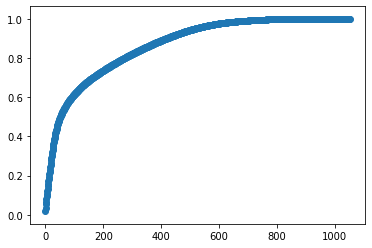

In [69]:
sum_importances = sum_and_plot_importances(variables, importances)

Perceba então que, a partir 800 variáveis, não muda mais a probabilidade

In [70]:
# Acumulado em ordem de importância
# do somatório das importâncias
sum_importances

,0,1
0,Var57,0.018025
1,Var113,0.035588
2,Var73,0.052926
3,Var153,0.066654
4,Var81,0.080371
...,...,...
1047,Var212_pApW,1.000000
1048,Var192_2AArEyQtC3,1.000000
1049,Var212_tDGH,1.000000
1050,Var212_missing,1.000000


In [0]:
def keep_vars(features, sum_importances, threshold):
  # Fazendo a sma acumulada até chegar a 1
  keep_vars = list(sum_importances[
    sum_importances.iloc[:, 1] <= threshold].iloc[:, 0]
  )
  features = features.loc[:, keep_vars] 
  # vai até keep_vars, o ponto em que chega a 1
  
  return features

In [0]:
features_c = keep_vars(features_c, sum_importances, threshold = 0.99)

Agora, reduzimos de 1052 para 685 colunas

In [73]:
features_c.shape

(50000, 684)

In [74]:
features_c.head()

,Var57,Var113,Var73,Var153,Var81,Var133,Var76,Var38,Var134,Var28,Var6,Var25,Var119,Var163,Var160,Var22,Var123,Var21,Var112,Var149,Var83,Var109,Var85,Var125,Var24,Var13,Var144,Var140,Var7,Var65,Var74,Var205_VpdQ,Var223_LM8l689qOp,Var205_sJzTlal,Var218_missing,Var132,Var205_09_Q,Var206_IYzP,Var218_cJvF,Var219_FzaX,...,Var207_5iay,Var195_I9xt3GMcxUnBZ,Var212_QsQAxv5,Var192_Yddr4R4FLE,Var197_nCqp,Var192_LDPvyxdtN_,Var197_pw40,Var207_0MCPoln,Var197_IIni,Var192_JMGq9at_88,Var212_MeOIHRG3F9,Var197_L_LK,Var192_IXSt0GoOh3,Var197_W5sH,Var192_H7er4Rdc_a,Var192_NFqq9at_88,Var192_xOXTmBkF1Q,Var195_ev6I,Var197_z8at,Var219_FqMWi1g,Var193_LrdVolaSGUfkVeWC,Var228_VjDE,Var212_fnfcPDe,Var212_4ylQpLr46xum2hHQ,Var192_zKnrjIPxRp,Var197_ZF5Q,Var197_EbEb,Var212_6z7lZp6XhQkon,Var197_5B99,Var192_bZkPe2fHUn,Var228_DU8B,Var192_l0JOj17ejg,Var192_dPsBcmRZ57,Var192_86ct0Gdncc,Var195_TnJpfvsJgF,Var192_hOVrjIQ6UK,Var212_TVE1uh4F_wOi_,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var197_12fX,Var192_czzTmBGxe3
0,4.076907,117625.60,36.0,1812252.0,7333.110000,1212385.0,1350864.0,3570.0,69134.0,166.56,1526.000000,128.0,1175.000000,38418.0,142.0,580.0,6.0,464.000000,168.0,397579.000000,5.0,104.00000,12.0,720.0,14.000000,184.0,9.000000,185.0,7.0,9.0,35.0,1,0,0,0,0.0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.408032,-356411.60,26.0,10439160.0,151098.900000,4136430.0,2872928.0,4764966.0,357038.0,353.52,525.000000,24.0,590.000000,238572.0,32.0,210.0,72.0,168.000000,40.0,278334.000000,25.0,40.00000,2.0,0.0,2.000000,0.0,9.000000,0.0,0.0,9.0,0.0,0,1,1,1,8.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6.599658,405104.00,130.0,9826360.0,16211.580000,3478905.0,1675776.0,5883894.0,248932.0,220.08,5236.000000,816.0,3230.000000,434946.0,206.0,1515.0,114.0,1212.000000,336.0,320565.000000,40.0,312.00000,58.0,5967.0,26.000000,904.0,36.000000,800.0,7.0,9.0,518.0,1,0,0,0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.988250,-275703.60,12.0,0.0,103084.052693,0.0,0.0,0.0,0.0,22.08,1326.437116,0.0,916.112185,0.0,0.0,0.0,0.0,234.518225,0.0,294920.804255,0.0,60.88866,0.0,0.0,4.507926,0.0,11.727665,0.0,0.0,9.0,0.0,1,1,0,0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.552446,10714.84,82.0,644836.0,37423.500000,150650.0,784448.0,0.0,66046.0,200.00,1029.000000,64.0,215.000000,0.0,2.0,80.0,0.0,64.000000,56.0,267162.000000,0.0,32.00000,0.0,15111.0,4.000000,3216.0,9.000000,3255.0,7.0,18.0,224.0,0,1,1,0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Dividindo os dados em dataset para treino e dataset para teste

Será 80% dos dados para treinar e 20% para testar o modelo

In [0]:
def split_datasets(features, outcome, test_size = 0.2):
  # train_test_split(
  #   as_labels_que_eu_quero, labels, porcentagem, 
  # stratify = outcome_proporção_de_clases, randoom = 0 pra sempre volta a mesma coisa )
  X_train, X_test, y_train, y_test = train_test_split(
      features, outcome, test_size = test_size,
      stratify = outcome, random_state = 0)
  y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
  
  return X_train, X_test, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = split_datasets(features_c, outcome)

In [77]:
X_train.shape

(40000, 684)

In [78]:
X_test.shape

(10000, 684)

### Modelagem preliminar

AUC e ROC: https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772

Quanto maior o AUC melhor.

#### Random Forest Classifier

In [0]:
def rfc_test(X_train, y_train, n_estimators = 100, cv = 5):
  np.random.seed(0)
  rfc = RandomForestClassifier(n_estimators = n_estimators, random_state = 0, n_jobs = -1)
  cv_scores = cross_val_score(rfc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
  print('Média dos cinco testes: ', cv_scores.mean())

In [80]:
rfc_test(X_train, y_train)

Média dos cinco testes:  0.62869289173648


#### Gradient Boosting Classifer (GBC)

Métodos com árvores de decisão: https://iaexpert.com.br/index.php/2019/04/18/xgboost-a-evolucao-das-arvores-de-decisao/

Gradient Boosting: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [0]:
# O ideal seria por cv = 10, mas ai precisaria de mais processamento
def gbc_test(X_train, y_train, n_estimators = 100, learning_rate = 0.1, cv = 5):
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                                  random_state = 0)
  cv_scores = cross_val_score(gbc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
  print('Média dos cinco testes: ', cv_scores.mean())

In [88]:
gbc_test(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Média dos cinco testes:  0.670172927197848


Vimos que o melhor resultado veio a apartir do GBC. Então, vamos analisá-lo melhor e observar seus parâmetros e melhorá-lo.

Vamos trabalhar com 6 parâmetros diferentes.

Uma boa prática e alterar parâmetros separadamente, de forma a obter um valor que otimiza o classificador só com aquele parâmetro. E, no final, juntar tudo.

## Otimizando o modelo GBC

### Template do GBC Otimizado

In [0]:
def optimize(n_estimators, learning_rate, min_samples_split, 
  min_samples_leaf, max_depth, max_features, subsample, params, cv = 5):
  
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators,
                                  learning_rate = learning_rate,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  subsample = subsample,
                                  random_state = 0)
  
  # Faz uma busca pelos melhores parâmetros
  grid_search = GridSearchCV(estimator = gbc, param_grid = params, 
      scoring = 'roc_auc', n_jobs = -1, iid = False, cv = cv)
  grid_search.fit(X_train, y_train)

  results = grid_search.cv_results_
  best_params = grid_search.best_params_
  best_score = grid_search.best_score_
  print(best_params, best_score)
  
  return gbc, best_params, best_score

In [0]:
# Variáveis para coletar os resultados
models = np.array([])
opt_params = dict()
scores = np.array([])

### Otimização no GBC 1 - Otimizar `n_estimators` para `learning_rate` = 0.1

O `GridSearchCV` é um classificador especial que buscará encontrar o melhor parâmetro para a variável que for passada como `None`.

Nesse caso, queremos encontrar o melhor valor para `n_estimators` para o cenário com `learning_rate = 0.1`.

In [0]:
# MODELO 0 : BUsca pelo melhor n_estimadotrs tendo learning_rate = 0.1
## Os outros valores nos colocamos o valor default da documentação do GBC
learning_rate = 0.1 
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8

params = {'n_estimators': range(50, 151, 10)} 
# queremos saber qual o melhor n_estimadtors para esse cenário na faixa desses valores

In [94]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 60} 0.6704309069650785


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param} ## ** serve para fundir dois dicionários
scores = np.append(scores, score)

In [96]:
models

array([GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=8,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=20, min_samples_split=250,
                           min_weight_fraction_leaf=0.0, n_estimators=None,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)], dtype=object)

In [97]:
# Parametros que foram otimizados (até agora)
opt_params

{'n_estimators': 60}

In [98]:
scores

array([0.67043091])

### Otimização no GBC 2 - Otimizando `max_depth` e `min_samples_split`

Agora queremos saber os melhores valores para esses parâmetros

In [0]:
# MODELO 1
n_estimators = opt_params['n_estimators'] # O resultado do anterior, pois é o ótimo
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {
    'max_depth': range(3, 12, 2), 
    'min_samples_split': range(150, 401, 50)
}

In [101]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'max_depth': 7, 'min_samples_split': 400} 0.6738436096009142


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [104]:
# Parametros que foram otimizados (até agora)
opt_params

{'max_depth': 7, 'min_samples_split': 400, 'n_estimators': 60}

### Otimizando `min_samples_leaf`

In [0]:
# MODELO 2
max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25, 61, 5)}

In [105]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'min_samples_leaf': 50} 0.6727304186548146


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [107]:
# Parametros que foram otimizados (até agora)
opt_params

{'max_depth': 7,
 'min_samples_leaf': 50,
 'min_samples_split': 400,
 'n_estimators': 60}

### Otimizando `max_features`

In [0]:
# MODELO 3
min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

In [109]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'max_features': 28} 0.6731279348348402


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [111]:
opt_params

{'max_depth': 7,
 'max_features': 28,
 'min_samples_leaf': 50,
 'min_samples_split': 400,
 'n_estimators': 60}

### Otimizando `subsample`

In [0]:
max_features = opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

In [113]:
# Exemplificando esse intervalo
np.append(np.arange(0.6, 1, 0.05), 1)

array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [114]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'subsample': 0.8000000000000002} 0.6731279348348402


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [116]:
opt_params

{'max_depth': 7,
 'max_features': 28,
 'min_samples_leaf': 50,
 'min_samples_split': 400,
 'n_estimators': 60,
 'subsample': 0.8000000000000002}

In [117]:
scores

array([0.67043091, 0.67384361, 0.67273042, 0.67312793, 0.67312793])

### Otimizando `n_estimators` e `learning_rate`

A otimização aqui será mais manual

In [0]:
def optimize2(n_estimators, learning_rate, min_samples_split, min_samples_leaf,
             max_depth, max_features, subsample, cv = 5):
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators,
                                  learning_rate = learning_rate,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  subsample = subsample,
                                  random_state = 0)
  cv_scores = cross_val_score(gbc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
  score = cv_scores.mean()
  plt.plot(np.append(scores, score))
  plt.title('n_estimators = {} / learning rate = {}'.format(n_estimators, learning_rate))
  
  return gbc, score


In [0]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

In [0]:
# MODELO 5 : dividir por 2 o learning rate e dobrando n_estimators
subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

In [121]:
learning_rate, n_estimators

(0.05, 120)

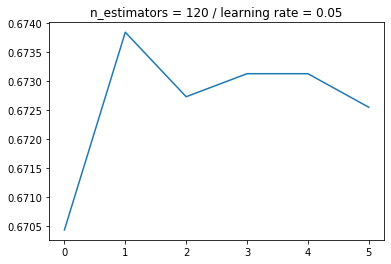

In [122]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

No gráfico acima, mostra os desempenhos dos nosso modelos otimizados. Perceba que a medaida que achamos valores ótimos ele melhora, mas nem sempre.

In [123]:
score

0.6725483920049433

In [124]:
scores

array([0.67043091, 0.67384361, 0.67273042, 0.67312793, 0.67312793])

In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [126]:
# MODELO 6
learning_rate /= 5
n_estimators *= 5
learning_rate, n_estimators

(0.01, 600)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


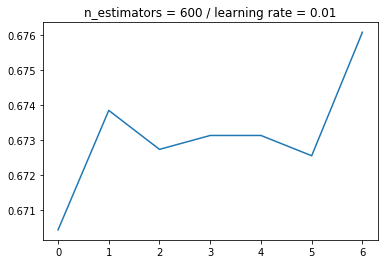

In [127]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [129]:
scores

array([0.67043091, 0.67384361, 0.67273042, 0.67312793, 0.67312793,
       0.67254839, 0.6760751 ])

In [130]:
# MODELO 7
learning_rate /= 2
n_estimators *= 2
learning_rate, n_estimators

(0.005, 1200)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


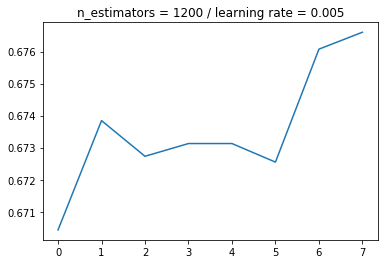

In [131]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [133]:
scores

array([0.67043091, 0.67384361, 0.67273042, 0.67312793, 0.67312793,
       0.67254839, 0.6760751 , 0.67660336])

In [134]:
# MODELO 8
learning_rate /= 5
n_estimators *= 5
learning_rate, n_estimators

(0.001, 6000)

In [135]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

## Escolhendo o Melhor Modelo e testando ele na base de teste

In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [137]:
scores

array([0.67043091, 0.67384361, 0.67273042, 0.67312793, 0.67312793,
       0.67254839, 0.6760751 , 0.67660336, 0.67660336])

In [138]:
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

Modelo de melhor desempenho:  7  - AUC:  0.676603356124293


In [0]:
best_model = models[scores.argmax()]

In [141]:
best_model.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [0]:
y_pred_probs = best_model.predict_proba(X_test)

In [0]:
y_pred_probs

array([[0.84254021, 0.15745979],
       [0.96644017, 0.03355983],
       [0.9460464 , 0.0539536 ],
       ...,
       [0.93890001, 0.06109999],
       [0.94081498, 0.05918502],
       [0.86984601, 0.13015399]])

In [0]:
y_pred_probs[:, 1]

array([0.15745979, 0.03355983, 0.0539536 , ..., 0.06109999, 0.05918502,
       0.13015399])

In [0]:
roc_auc_score(y_test, y_pred_probs[:, 1])

0.686824939672801

OBS: Fiz até chega ao último mdoelo, depois pulei tudo. Demora demais mesmo no Colab

## Resultados KDD Cup 2009

https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Results

## Conclusões

> Nesse exercício, foi possível modelar a possibilidade do cancelamento da conta com uma área sob a curva (AUC) de 0.6868

> É bom lembrar que AUC = 0.5 indica a linha de base, no caso de um modelo que faz predições aleatórias, e AUC = 1.0 indica um modelo ideal, que faz predições perfeitas

> Pode parecer que o AUC alcançado não é muito alto, mas também temos que considerar que o score mais alto no desafio público foi de 0.76

> Isso indica que, muito possivelmente, os dados fornecidos não são suficientes para fazer a modelagem perfeita do cancelamento da conta, e isso é sempre algo que devemos levar em consideração quando estamos tentando desenvolver modelos para problemas que não temos qualquer conhecimento prévio

> Fazendo uma analogia simples, seria como tentar predizer o peso de uma pessoa usando uma base de dados com apenas peso e altura de uma população: nós até conseguiríamos uma resposta razoável, já que as duas variáveis são correlacionadas, mas ela não seria perfeita simplesmente porque mais variáveis têm impacto no peso além da altura. É possível, portanto, que o maior score indique o melhor modelo que esses dados são capazes de fornecer

> Também devemos nos lembrar de que esses desafios geralmente são lançados sem que exista uma resposta prévia, eles servem justamente para que a própria comunidade tente encontrar soluções e comparar seus resultados entre si, e não com um "padrão ouro" ou a "resposta certa"

> Esses desafios são uma ótima oportunidade para se familiarizar com o ambiente real da carreira de um cientista de dados, e para conhecer e implementar na prática métodos e abordagens novas.

## Melhorias

> Testar outros modelos sempre é uma opção que se deve considerar. Nesse exercício, nós paramos nos classificadores do tipo gradient boosting, mas também poderíamos ter considerado modelos baseados em árvores de decisão mais novos, como o XGBoost, e até em redes neurais

> Os dados estão mascarados, o que dificulta qualquer feature engineering, já que para isso geralmente nós tentamos transformar as variáveis em função do conhecimento prévio que temos sobre elas. Por exemplo, se tivéssemos datas, poderíamos criar uma nova variável refletindo as estações do ano, se julgássemos relevante, mas nesse exercício ficamos restritos a tratar os dados com métricas estritamente numéricas, como o número de categorias que uma variável categórica possui, por não sabermos a que a variável se refere

> Mesmo com essas restrições, a seleção das melhores variáveis pode ser feita apenas considerando a natureza dos dados, e não da própria variável, e é possível testar outros métodos de seleção além daquele que nós usamos (seleção baseada em árvore de decisão)

> Também é possível melhorar o processo de fine-tuning da seguinte maneira: primeiro nós treinamos um hiperparâmetro num intervalo maior, por exemplo, [1, 2, 3, 4, 5], e depois que nós descobrimos o melhor parâmetro nessa faixa, por exemplo [2], podemos treinar de novo nas imediações desse valor, por exemplo [1.5, 2, 2.5], e assim por diante

> Ao final do treinamento apresentado no exercício (MODELO 8), nós observamos que a métrica continuava em tendência de aumentar, então talvez seja interessante continuar testando outros valores para learning rate/número de épocas

> Também é útil fazer um grid search com todos os parâmetros ao mesmo tempo, já que não necessariamente cada parâmetro se comporta da forma independente que nós consideramos, mas para isso é bom usar poucos valores para cada parâmetro (por isso é bom fazer uma seleção prévia da forma que nós fizemos), ou teríamos um número de modelos excessivamente grande pra testar, o que demanda maior capacidade de processamento

# Etapa 2: Modelando 'appetency' (tendência a usar novos produtos ou serviços)

O modelo para a nova variável de saída só precisa ser atualizado a partir da seleção de variáveis através de árvore de decisão. Primeiro carregaremos os dados correspondentes à variável `appetency`, depois presseguiremos com o pré-processamento do dataframe `features` até o final, repetindo o processo descrito acima.

In [0]:
outcome = pd.read_csv('orange_small_train_appetency.labels', header = None)

In [0]:
features_a = pd.get_dummies(features)

In [0]:
variables, importances = etc_importances(features_a, outcome)
sum_importances = sum_and_plot_importances(variables, importances)

In [0]:
features_a = keep_vars(features_a, sum_importances, threshold = 0.99)
features_a.shape

In [0]:
X_train, X_test, y_train, y_test = split_datasets(features_a, outcome)

In [0]:
rfc_test(X_train, y_train)

In [0]:
gbc_test(X_train, y_train)

In [0]:
models = np.array([])
opt_params = dict()
scores = np.array([])

In [0]:
### MODELO 0

learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(10, 101, 10)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 1

n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(1, 7, 1), 'min_samples_split': range(50, 151, 50)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 2

max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(1, 11, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 3

min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 4

max_features =  opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

In [0]:
### MODELO 5

subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 6

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 7

learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 8

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

In [0]:
best_model = models[scores.argmax()]
best_model.fit(X_train, y_train)

In [0]:
y_pred_probs = best_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_probs[:, 1])

**Conclusão:** O modelo otimizado atingiu AUC de `0.7955` no dataset de teste.

# Etapa 3: Modelando 'upselling' (propensão para comprar upgrades)

In [0]:
outcome = pd.read_csv(path + 'orange_small_train_upselling.labels', header = None)

In [0]:
features_u = pd.get_dummies(features)

In [0]:
variables, importances = etc_importances(features_u, outcome)
sum_importances = sum_and_plot_importances(variables, importances)

In [0]:
features_u = keep_vars(features_u, sum_importances, threshold = 0.99)
features_u.shape

In [0]:
X_train, X_test, y_train, y_test = split_datasets(features_u, outcome)

In [0]:
rfc_test(X_train, y_train)

In [0]:
gbc_test(X_train, y_train)

In [0]:
models = np.array([])
opt_params = dict()
scores = np.array([])

In [0]:
### MODELO 0

learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50, 101, 10)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 1

n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 2

max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(5, 50, 5)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 3

min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(20, 31, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 4

max_features =  opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

In [0]:
### MODELO 5

subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 6

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 7

learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 8

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

In [0]:
best_model = models[scores.argmax()]
best_model.fit(X_train, y_train)

In [0]:
y_pred_probs = best_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_probs[:, 1])

**Conclusão:** O modelo otimizado atingiu AUC de `0.7622` no dataset de teste.